In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import math
from datetime import datetime
from geopy import distance
from sklearn.preprocessing import OneHotEncoder


In [5]:
path = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/datasets_penguins'

files = os.listdir(path)

df_original = pd.concat([pd.read_csv(path + '/' + file) for file in files])

df = df_original.drop(columns=['equinox', 'original_track_id']).reset_index(drop=True)

In [6]:
# Test if there is more than one track_id bird_id pair per bird_id
print(df.groupby(['bird_id', 'track_id']).size().reset_index().groupby('bird_id').size().max())


4


--> use track_id

In [7]:
# Replace dd-mm-yyyy or yyyy-mm-dd with dd/mm/yyyy
date_target_format = '%d/%m/%Y'

for i in range(len(df)):
    # check if format is YYYY-MM-DD
    if '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d'): 
        df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%Y-%m-%d').strftime(date_target_format)
    # check if format is DD-MM-YYYY
    elif '-' in df.at[i, 'date_gmt'] and datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y'):
        df.at[i, 'date_gmt'] = datetime.strptime(df.at[i, 'date_gmt'], '%d-%m-%Y').strftime(date_target_format)

In [8]:
# Create datetime column
df['datetime'] = df['date_gmt'].astype(str) + ' ' + df['time_gmt'].astype(str)
df['datetime'] = pd.to_datetime(df['datetime'], format='%d/%m/%Y %H:%M:%S')

In [9]:
# Sort dataframe in date/time per bird and trip
df = df.sort_values(['track_id', 'date_gmt', 'time_gmt']).reset_index(drop=True)

In [10]:
print(len(df['datetime'].unique()), len(df['datetime']))
print(len(df['track_id'].unique()), len(df['track_id']))

241925 415643
981 415643


In [11]:
# Check for duplicated datetime values for each track_id
datetime_format = '%d/%m/%Y %H:%M:%S'
duplicated_datetimes = []
for i in range(1, len(df)):
    if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
        timestamp_1 = df.at[i-1, 'datetime']
        timestamp_2 = df.at[i, 'datetime']
        if timestamp_1 == timestamp_2:
            duplicated_datetimes.append(i)
print(duplicated_datetimes)
print(len(duplicated_datetimes))    


[1, 5, 6, 7, 9, 10, 12, 13, 15, 17, 18, 20, 21, 23, 25, 27, 29, 31, 33, 36, 38, 39, 41, 42, 44, 50, 52, 54, 59, 61, 62, 67, 72, 74, 75, 77, 79, 80, 81, 83, 84, 87, 88, 90, 91, 96, 98, 100, 103, 106, 108, 109, 111, 113, 117, 121, 124, 125, 126, 127, 129, 131, 132, 134, 135, 137, 138, 139, 141, 142, 145, 146, 150, 153, 155, 156, 158, 160, 162, 164, 166, 167, 169, 171, 173, 174, 176, 177, 180, 182, 183, 184, 185, 188, 189, 191, 193, 196, 198, 200, 201, 205, 209, 211, 213, 214, 218, 220, 222, 224, 225, 228, 229, 230, 233, 234, 235, 237, 238, 241, 243, 245, 246, 249, 251, 253, 255, 257, 259, 261, 263, 264, 265, 267, 268, 271, 272, 274, 280, 282, 286, 288, 289, 292, 293, 294, 296, 299, 301, 303, 305, 307, 309, 312, 313, 315, 317, 319, 321, 323, 325, 329, 333, 335, 337, 339, 340, 342, 344, 345, 348, 349, 352, 355, 358, 366, 369, 375, 377, 380, 382, 383, 386, 393, 394, 396, 398, 400, 402, 405, 407, 410, 411, 413, 416, 421, 423, 426, 427, 429, 430, 437, 443, 445, 447, 451, 453, 454, 456, 458, 4

In [12]:
# Woher die Duplikate? wahrscheinlich einfach messungen die gleichzeitig stattgefunden haben/falsch eingepflegt wurden
# Löschen der Duplikate
df = df.drop_duplicates(subset=['track_id', 'datetime']).reset_index(drop=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366065 entries, 0 to 366064
Data columns (total 20 columns):
 #   Column           Non-Null Count   Dtype         
---  ------           --------------   -----         
 0   dataset_id       366065 non-null  int64         
 1   scientific_name  366065 non-null  object        
 2   common_name      366065 non-null  object        
 3   site_name        366065 non-null  object        
 4   colony_name      366065 non-null  object        
 5   lat_colony       366065 non-null  float64       
 6   lon_colony       366065 non-null  float64       
 7   device           366065 non-null  object        
 8   bird_id          366065 non-null  object        
 9   track_id         366065 non-null  object        
 10  age              366065 non-null  object        
 11  sex              366065 non-null  object        
 12  breed_stage      366065 non-null  object        
 13  breed_status     366065 non-null  object        
 14  date_gmt         366

In [13]:
df = df.sort_values(['track_id', 'datetime']).reset_index(drop=True)

In [14]:
df['pos_bird'] = list(zip(df['latitude'], df['longitude']))
df['pos_colony'] = list(zip(df['lat_colony'], df['lon_colony']))

In [15]:
# breed_status is redundant

print(df['breed_stage'].nunique(), df['breed_status'].nunique())
print(df['breed_stage'].unique(), df['breed_status'].unique())
df = df.drop(columns='breed_status')

7 2
['non-breeding' 'chick-rearing' 'brood-guard' 'creche' 'incubation'
 'breeding' 'winter'] ['non-breeding' 'breeding']


## Features

In [16]:
# Calculate geodesic distance between bird and colony
# Elliposid used: WGS-84  

df['km_to_colony'] = df.apply(lambda row: distance.distance(row['pos_bird'], row['pos_colony']).km, axis=1)

In [17]:
# Below calculation is similar to performing weighted average

# Calculate mean distance and std per penguin
mean_distance_per_penguin = df.groupby('track_id')['km_to_colony'].mean()
std_distance_per_penguin = df.groupby('track_id')['km_to_colony'].std()

# Average over mean distances
mean_distance_overall = mean_distance_per_penguin.mean()
std_distance_overall = mean_distance_per_penguin.std()
print(mean_distance_overall, std_distance_overall)

82.1519173658347 237.7838928444612


In [18]:
# Position relative to colony
directions = ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N']

for i in range(len(df)):
    delta_lat = df.at[i,'latitude'] - df.at[i, 'lat_colony']
    delta_lon = df.at[i, 'longitude'] - df.at[i, 'lon_colony']
    degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180
    if degrees_temp < 0:
        degrees_final = degrees_temp + 360
    else:
        degrees_final = degrees_temp

    lookup = round(degrees_final/45) # because of 8 possible directions

    df.at[i, 'relative_position'] = directions[lookup]
    


In [19]:
# Direction of travel
# If bird_id changes: relative position to colony
# If bird_id stays the same: calculate direction of travel

df.at[0, 'direction_of_travel'] = df.at[0, 'relative_position']

for i in range(1, len(df)):
    if df.at[i, 'track_id'] != df.at[i-1,'track_id']:
        df.at[i, 'direction_of_travel'] = df.at[i, 'relative_position']
    else:
        delta_lat = delta_lat = df.iloc[i]['latitude'] - df.iloc[i-1]['latitude']
        delta_lon = df.iloc[i]['longitude'] - df.iloc[i-1]['longitude']
        degrees_temp = math.atan2(delta_lat, delta_lon)/math.pi*180

        if degrees_temp < 0:
            degrees_final = degrees_temp + 360
        else:
            degrees_final = degrees_temp

        lookup = round(degrees_final/45)

        df.at[i, 'direction_of_travel'] = directions[lookup]


In [20]:
# Distance travelled between each measure (might define previous steps as formulas and apply them directly)

df['km_since_last_measure'] = 0
df['km_since_last_measure'] = df['km_since_last_measure'].astype(float)
for i in range(1, len(df)):
    if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
        df.at[i, 'km_since_last_measure'] = distance.distance(df.at[i,'pos_bird'], df.at[i-1,'pos_bird']).km
    else:
        df.at[i, 'km_since_last_measure'] = 0

In [21]:
# Distace North, East, South, West

df['delta_km_north'] = 0
df['delta_km_north'] = df['delta_km_north'].astype(float)
df['delta_km_south'] = 0
df['delta_km_south'] = df['delta_km_south'].astype(float)

for i in range(1, len(df)):
    start = (0, df.at[i-1, 'longitude'])
    finish = (0, df.at[i, 'longitude'])
    delta = distance.distance(start, finish).km
    if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
        if delta > 0:
            df.at[i, 'delta_km_north'] = delta
        if delta < 0:
            df.at[i, 'delta_km_south'] = delta
    else:
        df.at[i, 'delta_km_north'] = 0
        


df['delta_km_east'] = 0
df['delta_km_east'] = df['delta_km_east'].astype(float)
df['delta_km_west'] = 0
df['delta_km_west'] = df['delta_km_west'].astype(float)

for i in range(1, len(df)):
    start = (df.at[i-1, 'latitude'], 0)
    finish = (df.at[i, 'latitude'], 0)
    delta = distance.distance(start, finish).km
    if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
        if delta > 0:
            df.at[i, 'delta_km_east'] = delta
        elif delta < 0:
            df.at[i, 'delta_km_west'] = delta
    else:
        df.at[i, 'delta_km_east'] = 0

In [22]:
# Time difference betweeen measures in minutes(time_gmt = hh:mm:ss, date_gmt = dd/mm/yyyy)

# datetime_format = '%d/%m/%Y %H:%M:%S'
# df = df.sort_values(['track_id', 'date_gmt', 'time_gmt']).reset_index(drop=True)

df['minutes_since_last_measure'] = 0
df['minutes_since_last_measure'] = df['minutes_since_last_measure'].astype(float)
for i in range(1, len(df)):
    if df.at[i, 'track_id'] == df.at[i-1, 'track_id']:
        timestamp_1 = df.at[i-1, 'datetime']
        timestamp_2 = df.at[i, 'datetime']
        df.at[i,'minutes_since_last_measure'] = (timestamp_2 - timestamp_1).total_seconds()/60
    else:
        df.at[i, 'minutes_since_last_measure'] = 0

In [23]:
print(df['minutes_since_last_measure'].describe())
# Max is around 80 days (double-checked with excel)

count    366065.000000
mean         82.864815
std        1136.873220
min           0.000000
25%           4.883333
50%          15.000000
75%          40.000000
max      126200.000000
Name: minutes_since_last_measure, dtype: float64


In [24]:
# Check how many values are above 1 day
print(len(df[df['minutes_since_last_measure'] > 1440]))

2683


In [25]:
# Check how many values are "extremely high"
print(len(df[df['minutes_since_last_measure'] > 5000]))

247


## Question: what is reasonable?

In [26]:
# Filter by minutes since last measure that are not greater than 1 day
df_filtered = df[df['minutes_since_last_measure'] <= 1440].reset_index(drop=True)
df_filtered = df_filtered[df_filtered['minutes_since_last_measure'] > 0].reset_index(drop=True) # Because around 920 zero values 
print(df_filtered['minutes_since_last_measure'].describe())

count    362401.000000
mean         40.098865
std         105.016756
min           0.016667
25%           4.883333
50%          15.000000
75%          40.000000
max        1440.000000
Name: minutes_since_last_measure, dtype: float64


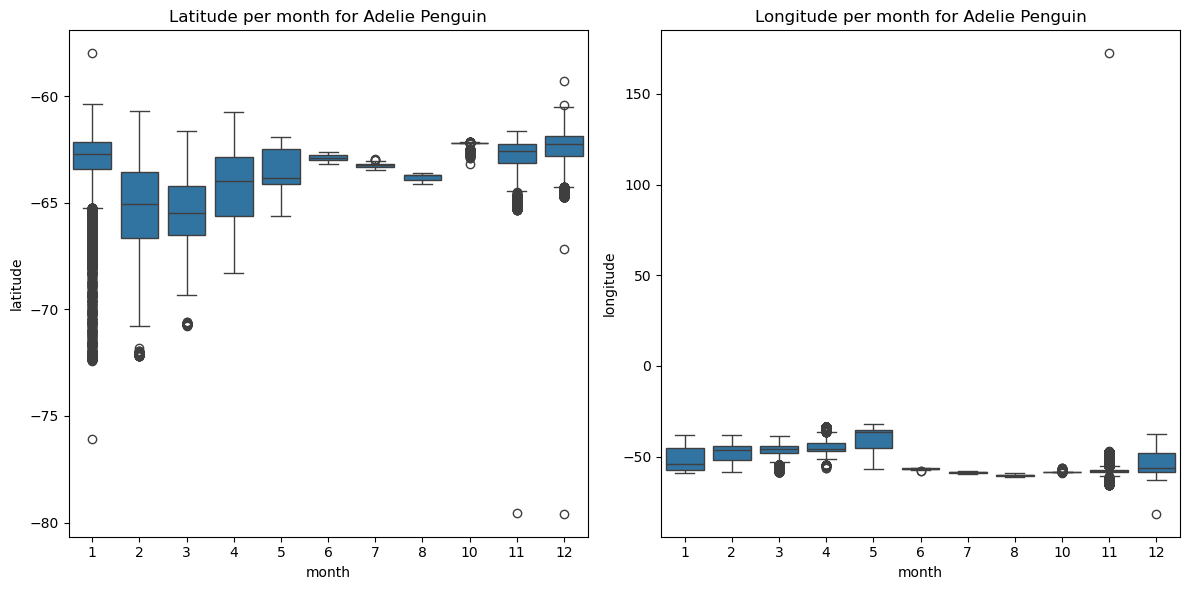

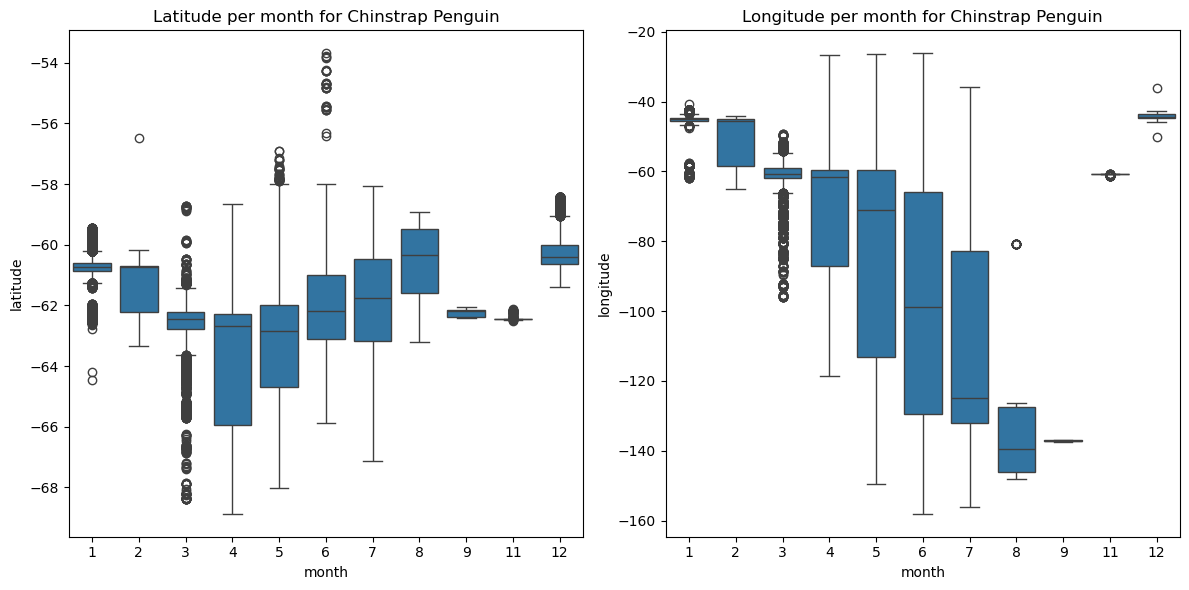

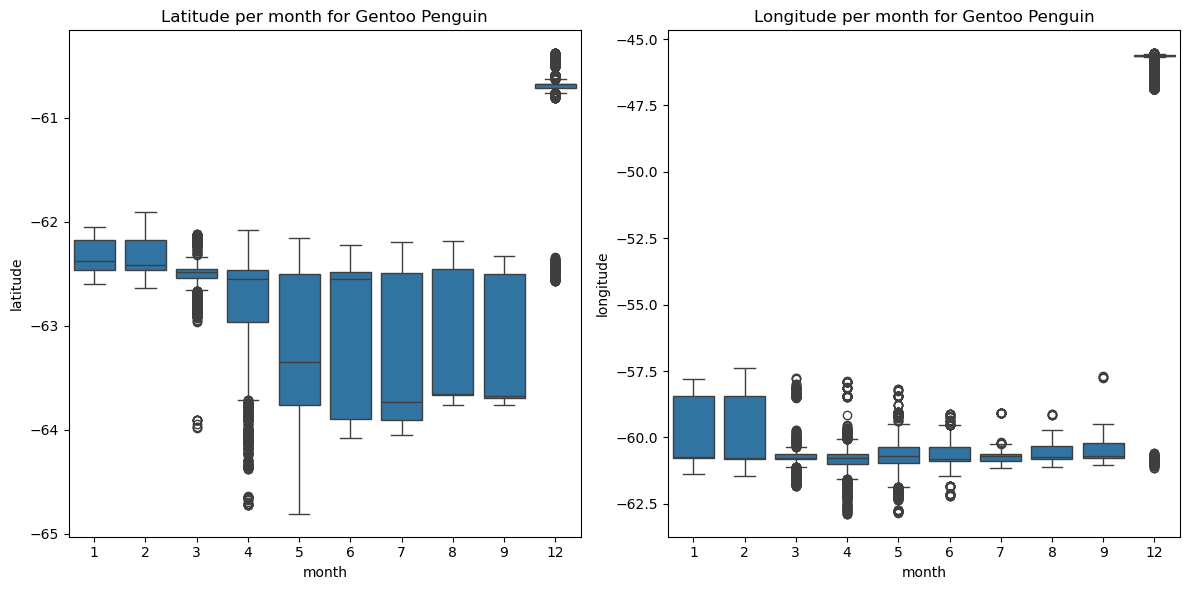

In [27]:
# Plot coordinates of different species per month (no matter the year)

df['month'] = df['date_gmt'].str.split('/').str[1]
df['month'] = df['month'].astype(int)
# create one plot per species, with moth on x-axis and latitude on y-axis and one per species with month on x-axis and longitude on y-axis
species = df['common_name'].unique()

months = ['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(12, 6))
    sns.boxplot(x='month', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per month for ' + specie)
    sns.boxplot(x='month', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per month for ' + specie)
    plt.tight_layout()
    plt.show()


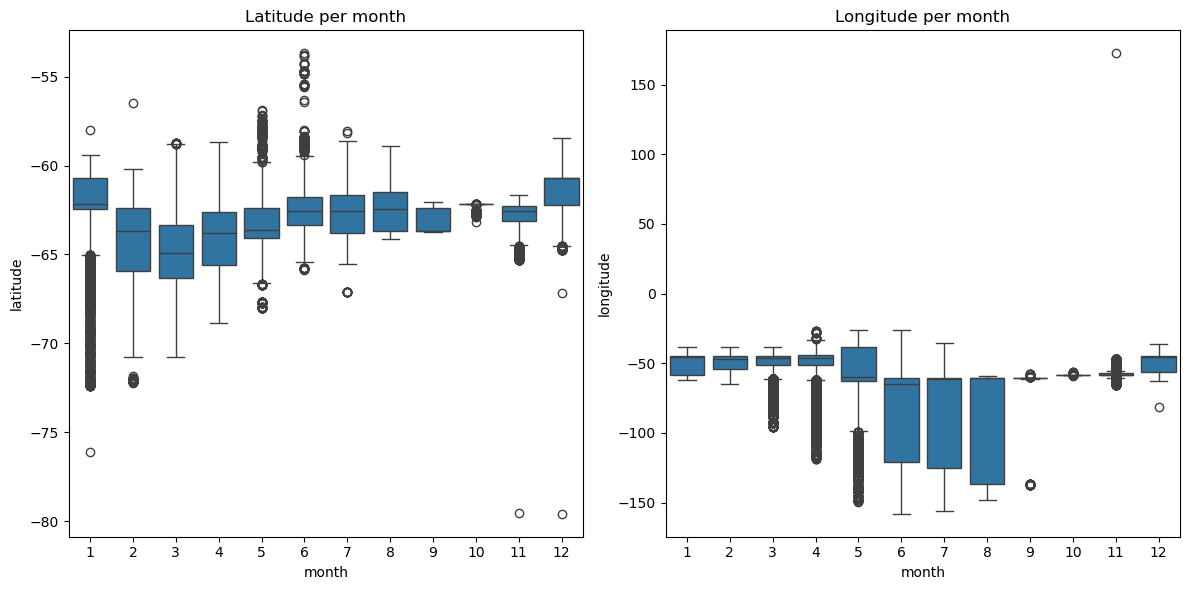

In [28]:

fig, ax = plt.subplots(1, 2, figsize=(12, 6))
sns.boxplot(x='month', y='latitude', data=df, ax=ax[0])
ax[0].set_title('Latitude per month')
sns.boxplot(x='month', y='longitude', data=df, ax=ax[1])
ax[1].set_title('Longitude per month')
plt.tight_layout()
plt.show()

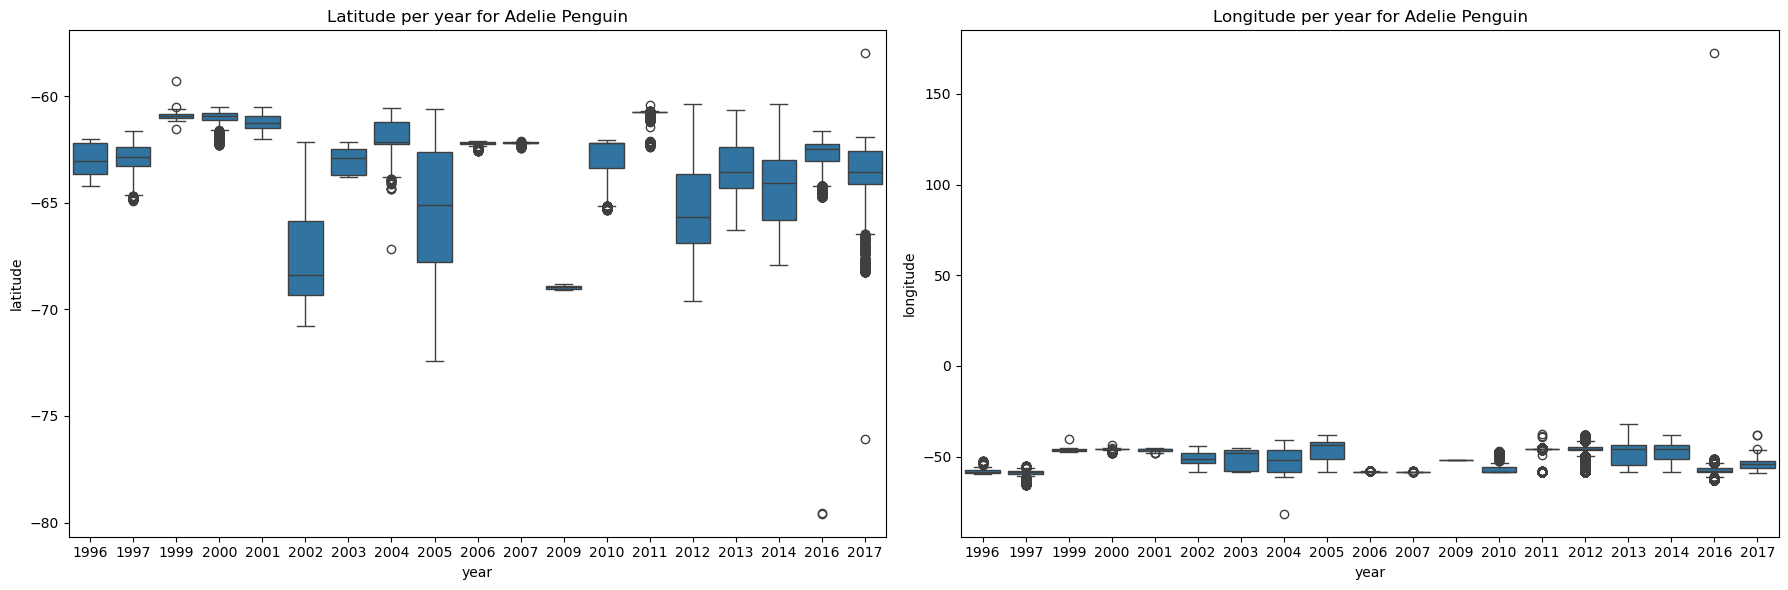

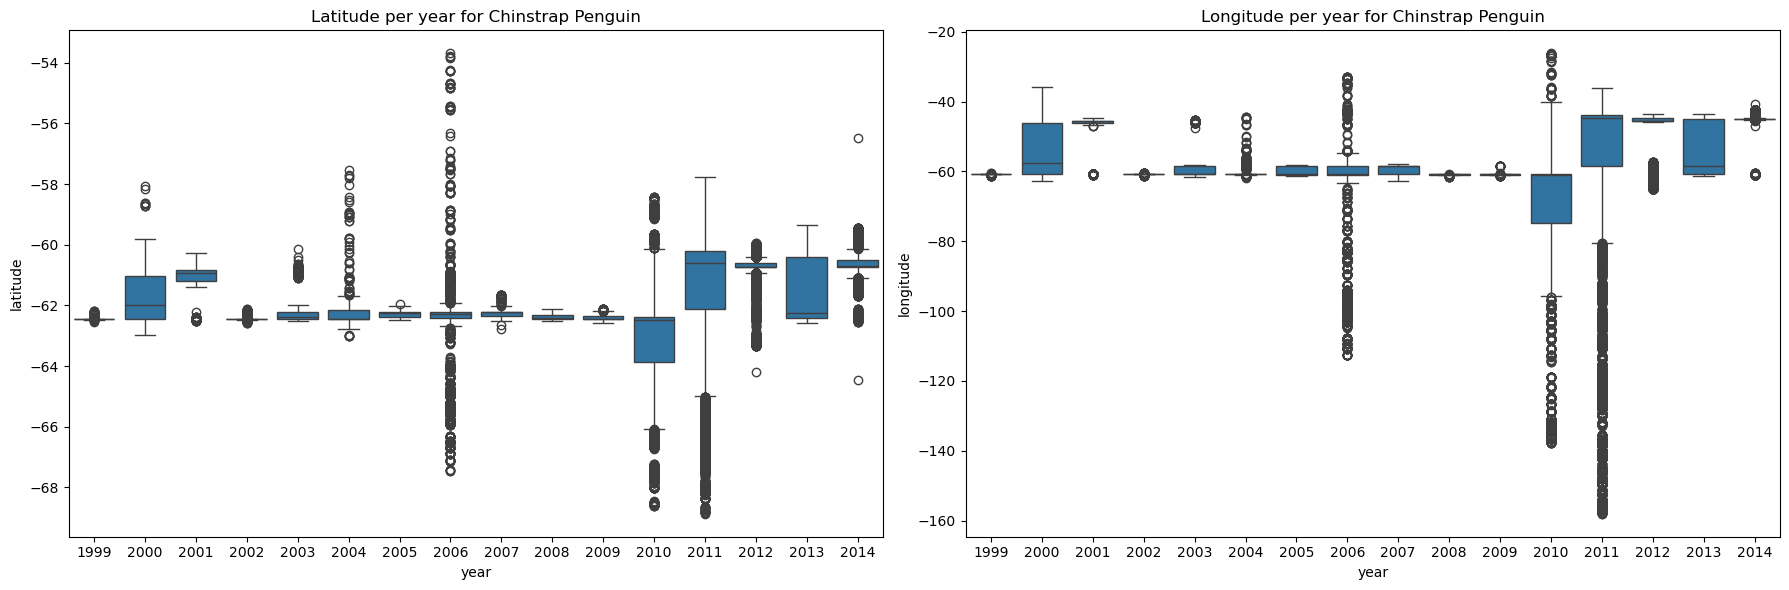

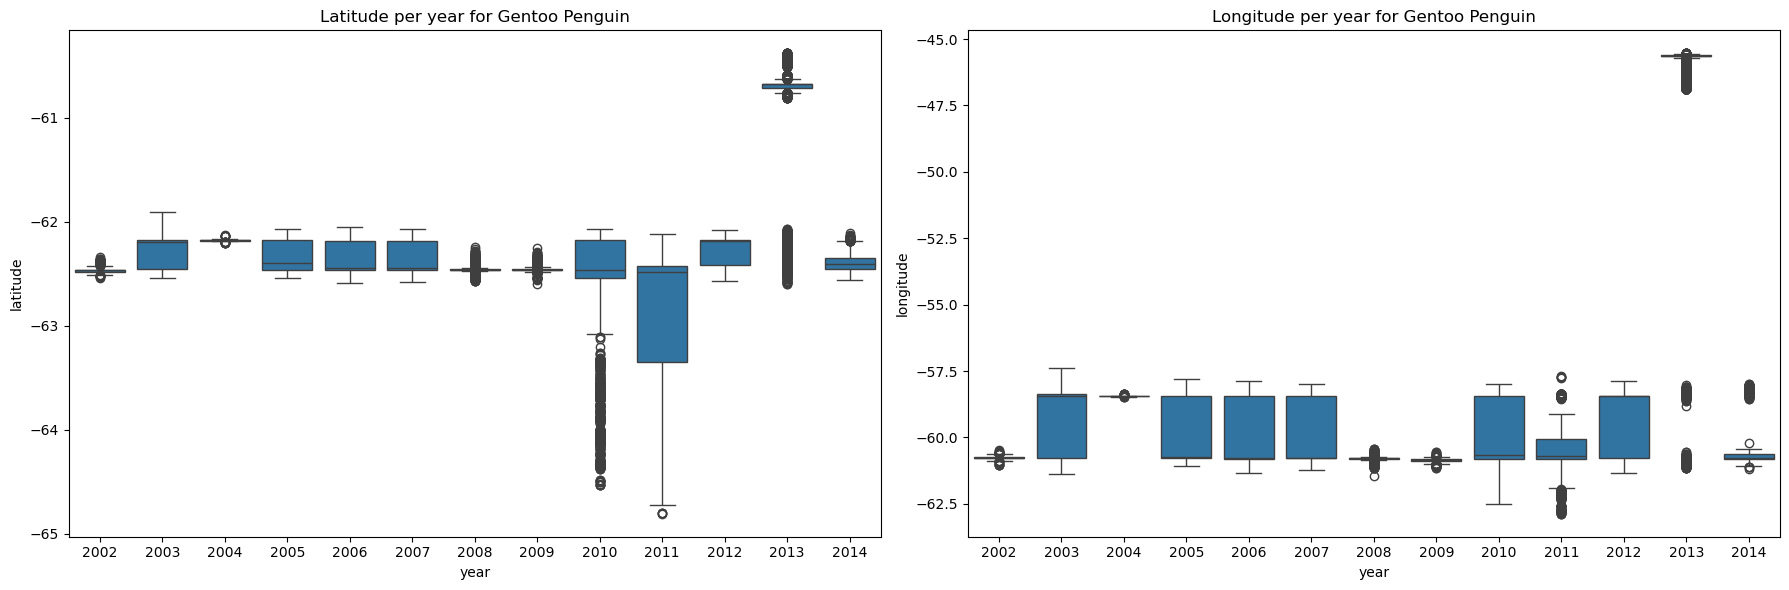

In [29]:
df['year'] = df['date_gmt'].str.split('/').str[2]
df['year'] = df['year'].astype(int)

for specie in species:
    df_specie = df[df['common_name'] == specie]
    fig, ax = plt.subplots(1, 2, figsize=(18, 6))
    sns.boxplot(x='year', y='latitude', data=df_specie, ax=ax[0])
    ax[0].set_title('Latitude per year for ' + specie)
    sns.boxplot(x='year', y='longitude', data=df_specie, ax=ax[1])
    ax[1].set_title('Longitude per year for ' + specie)
    plt.tight_layout()
    plt.show()

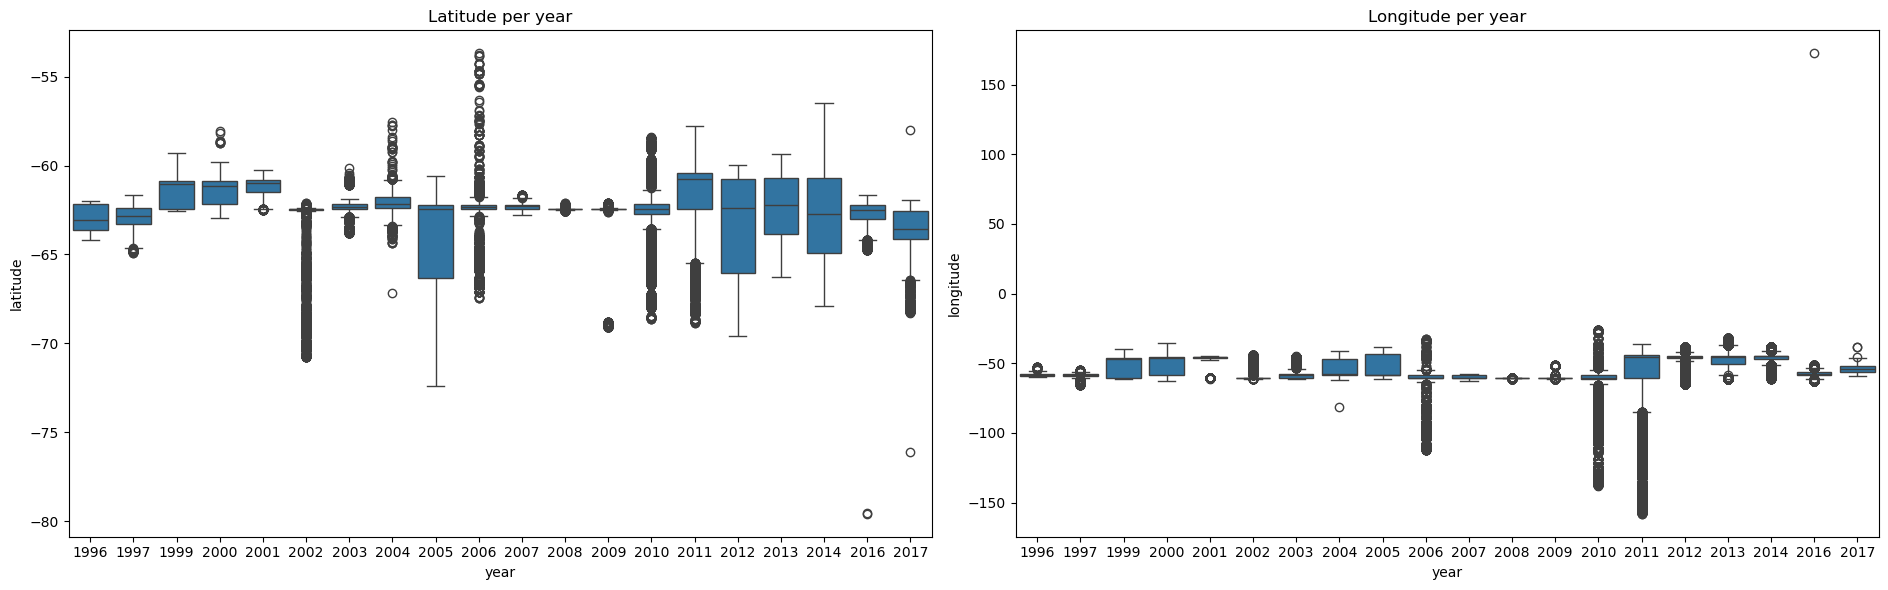

In [30]:
# plots in general
fig, ax = plt.subplots(1, 2, figsize = (19, 6))
sns.boxplot(x='year', y='latitude', data = df, ax=ax[0])
ax[0].set_title('Latitude per year')
sns.boxplot(x='year', y='longitude', data = df, ax=ax[1])
ax[1].set_title('Longitude per year')
plt.tight_layout()
plt.show()

# x axis label anpassen

In [31]:
print(df.columns)

Index(['dataset_id', 'scientific_name', 'common_name', 'site_name',
       'colony_name', 'lat_colony', 'lon_colony', 'device', 'bird_id',
       'track_id', 'age', 'sex', 'breed_stage', 'date_gmt', 'time_gmt',
       'latitude', 'longitude', 'argos_quality', 'datetime', 'pos_bird',
       'pos_colony', 'km_to_colony', 'relative_position',
       'direction_of_travel', 'km_since_last_measure', 'delta_km_north',
       'delta_km_south', 'delta_km_east', 'delta_km_west',
       'minutes_since_last_measure', 'month', 'year'],
      dtype='object')


In [32]:
# TargetEncoder vllt lieber benutzen ? (nochmal reinlesen)

# One Hot Encoding:
categorical_cols = ['breed_stage', 'relative_position', 'direction_of_travel']
encoder = OneHotEncoder(sparse_output=False)
one_hot_encoded = encoder.fit_transform(df[categorical_cols])

one_hot_df = pd.DataFrame(one_hot_encoded, columns = encoder.get_feature_names_out(categorical_cols))

df_encoded = pd.concat([df, one_hot_df], axis=1)
df_encoded = df_encoded.drop(categorical_cols, axis=1)

df = df_encoded

It seems like there is not much movement between measures, however they just "stay" far away from the colony
--> more understanding of penguins is needed --> read

In [33]:
# save df to csv and store in zip file

path_new = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/data'
#df_encoded.to_csv(path_new + '/' + 'penguins_cleaned.csv', index=False, compression='zip')

df.to_csv(path_new + '/' +'penguins_cleaned.zip', compression={'method': 'zip', 'archive_name': 'penguins_cleaned.csv'}, index=False)

# Create new dataframe that averages each day per track id and repeat above steps

In [34]:
# Average time stamps to match weather: One per day
# Try to get a distribution for those accumulated time stamps --> one for each day per unique_id
df['date_gmt'] = pd.to_datetime(df['date_gmt'], format='%d/%m/%Y')

aggregate_cols = ['latitude', 'longitude', 'lat_colony', 'lon_colony', 'km_to_colony', 'km_since_last_measure', 
                    'delta_km_north', 'delta_km_south', 'delta_km_east', 
                    'delta_km_west', 'minutes_since_last_measure']

# Calculate mean
df_mean = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].mean().reset_index()
df_mean.columns = ['track_id', 'date_gmt'] + [f'{col}_mean' for col in aggregate_cols]

# Calculate standard deviation
# Entscheidung ob ddof = 1 (sample) oder ddof = 0 (population) -->Tradeoff
df_std = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].std(ddof=0).reset_index()
df_std.columns = ['track_id', 'date_gmt'] + [f'{col}_std' for col in aggregate_cols]

#df_min
df_min = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].min().reset_index()
df_min.columns = ['track_id', 'date_gmt'] + [f'{col}_min' for col in aggregate_cols]

#df_max
df_max = df.groupby(['track_id', 'date_gmt'])[aggregate_cols].max().reset_index()
df_max.columns = ['track_id', 'date_gmt'] + [f'{col}_max' for col in aggregate_cols]

# Merge dataframes
df_penguins_pt1 = pd.merge(df_mean, df_std, on=['track_id', 'date_gmt'])

df_penguins_pt2 = pd.merge(df_min, df_max, on=['track_id', 'date_gmt'])

df_penguins_final = pd.merge(df_penguins_pt1, df_penguins_pt2, on=['track_id', 'date_gmt'])

# Lookup operation to add 'common_name', 'site_name','colony_name' back based on track id
df_subset = df.drop_duplicates(subset='track_id')
add_back = ['common_name', 'site_name','colony_name']
for column in add_back:
    df_penguins_final[column] = df_penguins_final['track_id'].map(df_subset.set_index('track_id')[column])



In [35]:
# Search for track_ids that are only recorded once
print(df_penguins_final['track_id'].value_counts().min())

1


In [36]:
print(df_penguins_final.isnull().sum())

# print out the rows with zero values in the std columns in general

# should not happen
# REASON?
# Pandas calculates std dev with 1/N-1. By setting ddof = 0, it calculates by 1/N
# --> issue solved. However: Bias?
# Could be an issue, ask linda


track_id                           0
date_gmt                           0
latitude_mean                      0
longitude_mean                     0
lat_colony_mean                    0
lon_colony_mean                    0
km_to_colony_mean                  0
km_since_last_measure_mean         0
delta_km_north_mean                0
delta_km_south_mean                0
delta_km_east_mean                 0
delta_km_west_mean                 0
minutes_since_last_measure_mean    0
latitude_std                       0
longitude_std                      0
lat_colony_std                     0
lon_colony_std                     0
km_to_colony_std                   0
km_since_last_measure_std          0
delta_km_north_std                 0
delta_km_south_std                 0
delta_km_east_std                  0
delta_km_west_std                  0
minutes_since_last_measure_std     0
latitude_min                       0
longitude_min                      0
lat_colony_min                     0
l

In [37]:
df_penguins_final.to_csv(path_new + '/' +'penguins_final.zip', compression={'method': 'zip', 'archive_name': 'penguins_final.csv'})

## Save unique dates as JSON to access in API call

In [38]:
# transform date back to string
df_penguins_final['date_gmt'] = df_penguins_final['date_gmt'].astype(str)

# extract each unique combination of year, month and day in a dictionary
unique_dates = df_penguins_final['date_gmt'].unique()
unique_dates_dict = {}

for date in unique_dates:
    year = date.split('-')[0]
    month = date.split('-')[1]
    day = date.split('-')[2]
    unique_dates_dict[date] = {'year': year, 'month': month, 'day': day}


np_test = np.array([unique_dates_dict[date] for date in unique_dates])
print(unique_dates_dict)
print(np_test)

{'2016-11-10': {'year': '2016', 'month': '11', 'day': '10'}, '2016-11-11': {'year': '2016', 'month': '11', 'day': '11'}, '2016-11-19': {'year': '2016', 'month': '11', 'day': '19'}, '2016-11-20': {'year': '2016', 'month': '11', 'day': '20'}, '2017-02-06': {'year': '2017', 'month': '02', 'day': '06'}, '2017-02-07': {'year': '2017', 'month': '02', 'day': '07'}, '2017-02-08': {'year': '2017', 'month': '02', 'day': '08'}, '2017-02-09': {'year': '2017', 'month': '02', 'day': '09'}, '2017-02-10': {'year': '2017', 'month': '02', 'day': '10'}, '2017-02-11': {'year': '2017', 'month': '02', 'day': '11'}, '2017-02-12': {'year': '2017', 'month': '02', 'day': '12'}, '2016-11-08': {'year': '2016', 'month': '11', 'day': '08'}, '2016-11-12': {'year': '2016', 'month': '11', 'day': '12'}, '2016-11-13': {'year': '2016', 'month': '11', 'day': '13'}, '2016-11-14': {'year': '2016', 'month': '11', 'day': '14'}, '2016-11-15': {'year': '2016', 'month': '11', 'day': '15'}, '2016-11-16': {'year': '2016', 'month':

In [39]:
import json

path_json = '/Users/philipp/Documents/02_Master_Uni/Uni_Tübingen/Semester_1/06 Data Literacy/02 Project/projectP/era5_datasets'
#df_encoded.to_csv(path_json + '/' + 'penguins_cleaned.csv', index=False, compression='zip')
json.dump(unique_dates_dict, open(path_json + '/' + 'unique_dates_dict.json', 'w'))


# Get insights into the penguins behaviour

In [40]:
# "spread"(how dense are they located around the colony) 
    # --> percentage of penguins of colony that are closer than x kilometers to colony (on average)
colonies = df['colony_name'].unique()

for colony in colonies:
    df_colony = df_penguins_final[df_penguins_final['colony_name'] == colony]
    
    '''DOUBLE CHECK CALCULATION OF SPREAD'''
    
    spread = df_colony['km_to_colony_mean'].std(ddof=1)
    print(colony,':', spread)

# filter by breeding stages and look how it is then



King George Island : 156.8922767009632
Hope Bay : 204.50053560976153
Powell Island/Peng colony : 310.0954540651711
Signy Island/Gourlay : 253.47445183153857
Laurie Island/Cape Geddes : 33.81119977181794
Signy Island/North Point : 411.1664295523661
Admiralty Bay : 202.9981047788414
Cape Shirreff : 695.084249143909


In [41]:
# calculate spread for different species
species = df['common_name'].unique()
for specie in species:
    print(specie)
    for colony in df[df['common_name'] == specie]['colony_name'].unique():
        df_specie = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony)]
        
        '''DOUBLE CHECK CALCULATION OF SPREAD'''
        
        spread = df_specie['km_to_colony_mean'].std(ddof=1)
        print(colony, spread)

Adelie Penguin
King George Island 156.8922767009632
Hope Bay 204.50053560976153
Powell Island/Peng colony 241.1019912032257
Signy Island/Gourlay 234.41072806291984
Signy Island/North Point 397.9617597992179
Admiralty Bay 252.13850471057341
Chinstrap Penguin
Laurie Island/Cape Geddes 33.81119977181794
Signy Island/Gourlay 15.947249101383012
Powell Island/Peng colony 20.863095171907652
Admiralty Bay 191.11673222630228
Cape Shirreff 898.6426014496931
Gentoo Penguin
Signy Island/North Point 14.226600107963902
Admiralty Bay 9.8093438462616
Cape Shirreff 48.9572812598909


In [42]:
# hier evtl violin plot per colony


In [43]:
# Mean deviation
species = df['common_name'].unique()
for specie in species:
    print(specie)
    for colony in df[df['common_name'] == specie]['colony_name'].unique():
        df_specie = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony)]
        
        # Calculate mean deviation manually
        mean_value = df_specie['km_to_colony_mean'].mean()
        mean_deviation = (df_specie['km_to_colony_mean'] - mean_value).abs().mean()
        print(colony, mean_deviation)

Adelie Penguin
King George Island 129.4704820208191
Hope Bay 164.31657218913702
Powell Island/Peng colony 188.5177415557273
Signy Island/Gourlay 200.64823394539997
Signy Island/North Point 340.630021992136
Admiralty Bay 187.6252134675522
Chinstrap Penguin
Laurie Island/Cape Geddes 19.193426327121703
Signy Island/Gourlay 12.324104237789548
Powell Island/Peng colony 12.005098504707792
Admiralty Bay 96.47090182991843
Cape Shirreff 571.9082535242949
Gentoo Penguin
Signy Island/North Point 8.846322623042843
Admiralty Bay 6.105893753653458
Cape Shirreff 32.132810331351685


# do it in time series perspective


In [44]:
print(df_penguins_final.columns)

Index(['track_id', 'date_gmt', 'latitude_mean', 'longitude_mean',
       'lat_colony_mean', 'lon_colony_mean', 'km_to_colony_mean',
       'km_since_last_measure_mean', 'delta_km_north_mean',
       'delta_km_south_mean', 'delta_km_east_mean', 'delta_km_west_mean',
       'minutes_since_last_measure_mean', 'latitude_std', 'longitude_std',
       'lat_colony_std', 'lon_colony_std', 'km_to_colony_std',
       'km_since_last_measure_std', 'delta_km_north_std', 'delta_km_south_std',
       'delta_km_east_std', 'delta_km_west_std',
       'minutes_since_last_measure_std', 'latitude_min', 'longitude_min',
       'lat_colony_min', 'lon_colony_min', 'km_to_colony_min',
       'km_since_last_measure_min', 'delta_km_north_min', 'delta_km_south_min',
       'delta_km_east_min', 'delta_km_west_min',
       'minutes_since_last_measure_min', 'latitude_max', 'longitude_max',
       'lat_colony_max', 'lon_colony_max', 'km_to_colony_max',
       'km_since_last_measure_max', 'delta_km_north_max', 'delta

In [48]:
# add year back for calculation
# extract each unique combination of year, month and day in a dictionary
unique_dates = df_penguins_final['date_gmt'].unique()
for date in unique_dates:
    year = date.split('-')[0]
    df_penguins_final.loc[df_penguins_final['date_gmt'] == date, 'year'] = year
df_penguins_final = df_penguins_final.sort_values('year').reset_index(drop=True)

In [49]:
# print number of oberverations per year and species
species = df_penguins_final['common_name'].unique()
years = df_penguins_final['year'].unique()
for specie in species:
    for year in years:
        print(specie, year, len(df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['year'] == year)]))

Adelie Penguin 1996 46
Adelie Penguin 1997 198
Adelie Penguin 1999 34
Adelie Penguin 2000 75
Adelie Penguin 2001 19
Adelie Penguin 2002 77
Adelie Penguin 2003 69
Adelie Penguin 2004 212
Adelie Penguin 2005 295
Adelie Penguin 2006 41
Adelie Penguin 2007 19
Adelie Penguin 2008 0
Adelie Penguin 2009 10
Adelie Penguin 2010 122
Adelie Penguin 2011 44
Adelie Penguin 2012 1081
Adelie Penguin 2013 720
Adelie Penguin 2014 766
Adelie Penguin 2016 1265
Adelie Penguin 2017 937
Chinstrap Penguin 1996 0
Chinstrap Penguin 1997 0
Chinstrap Penguin 1999 46
Chinstrap Penguin 2000 273
Chinstrap Penguin 2001 121
Chinstrap Penguin 2002 155
Chinstrap Penguin 2003 177
Chinstrap Penguin 2004 133
Chinstrap Penguin 2005 124
Chinstrap Penguin 2006 495
Chinstrap Penguin 2007 226
Chinstrap Penguin 2008 64
Chinstrap Penguin 2009 155
Chinstrap Penguin 2010 503
Chinstrap Penguin 2011 839
Chinstrap Penguin 2012 465
Chinstrap Penguin 2013 147
Chinstrap Penguin 2014 413
Chinstrap Penguin 2016 0
Chinstrap Penguin 2017 0


Could be beneficial to filter out years with less than 30 obs.
Also for interpretability, from 2012 on,  it is mainly adelie penguins

In [ ]:
# filter out years with less than 30 observations?


In [87]:
# for all penguins independent of species or colony:
mean_deviation_results = []
for year in df_penguins_final['year'].unique():
    mean_value = df_penguins_final[df_penguins_final['year'] == year]['km_to_colony_mean'].mean()
    # mean_deviation = (df_penguins_final[df_penguins_final['year'] == year]['km_to_colony_mean'] - mean_value).abs().mean()
    mean_deviation_results.append({'year': year, 'mean distance': mean_value})
    print(year, mean_value)

# Convert results to DataFrame
results_df = pd.DataFrame(mean_deviation_results)



1996 123.10515308378803
1997 102.65370037206847
1999 23.42020054671845
2000 101.11002235087192
2001 23.173556823468534
2002 196.49549746428312
2003 58.717886329062395
2004 94.01640747405779
2005 258.9607865031787
2006 174.91304680791905
2007 8.031210105858838
2008 6.394029345248861
2009 41.87220510621318
2010 234.35675109569837
2011 405.01535757678124
2012 302.93701584130474
2013 201.25964365864428
2014 240.98925370358484
2016 101.39402445067174
2017 247.09469035537688


/var/folders/pf/pkxhbds54clgt4d3jrz5l8kw0000gn/T/ipykernel_23274/4188710153.py:3: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x='year', y='mean distance', data=results_df, palette='pastel')


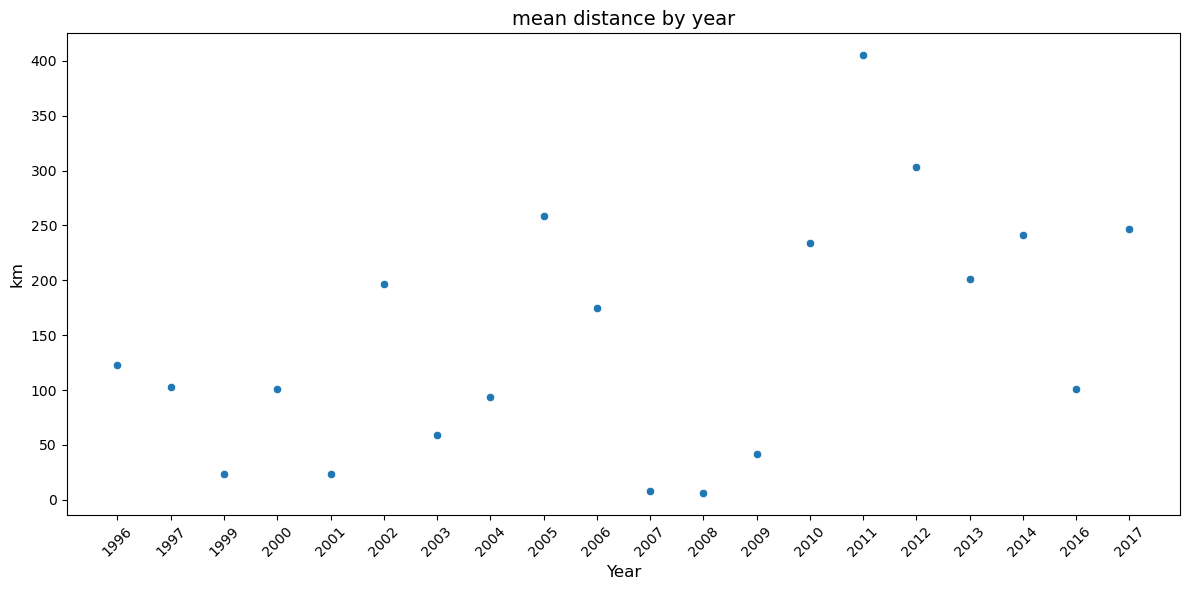

In [89]:

plt.figure(figsize=(12, 6))

sns.scatterplot(x='year', y='mean distance', data=results_df, palette='pastel')

# Customization
plt.title('mean distance by year', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('km', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [90]:
# do it for each species independent of colony and in percent
# DOES IT MAKE SENSE TO USE KM TO COLONY? I DONT THINK SO
# mean km to colony

species = df['common_name'].unique()
years = df_penguins_final['year'].unique()
results_species = []
for year in years:
    print(year)
    for specie in species:
        print(specie)
        df_specie = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['year'] == year)]
        # Calculate mean deviation manually
        mean_value = df_specie['km_to_colony_mean'].mean()
        # mean_deviation = (df_specie['km_to_colony_mean'] - mean_value).abs().mean()
        # mean_deviation_percent = mean_deviation/mean_value * 100
        results_species.append({'year': year, 'species': specie, 'mean value': mean_value})
        print(mean_deviation)

# Convert results to DataFrame
results_species = pd.DataFrame(results_species)

1996
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
1997
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
1999
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2000
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2001
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2002
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2003
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2004
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2005
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2006
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2007
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2008
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2009
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2010
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2011
Adelie Penguin
nan
Chinstrap Penguin
nan
Gentoo Penguin
nan
2012
Adelie Penguin
nan
C

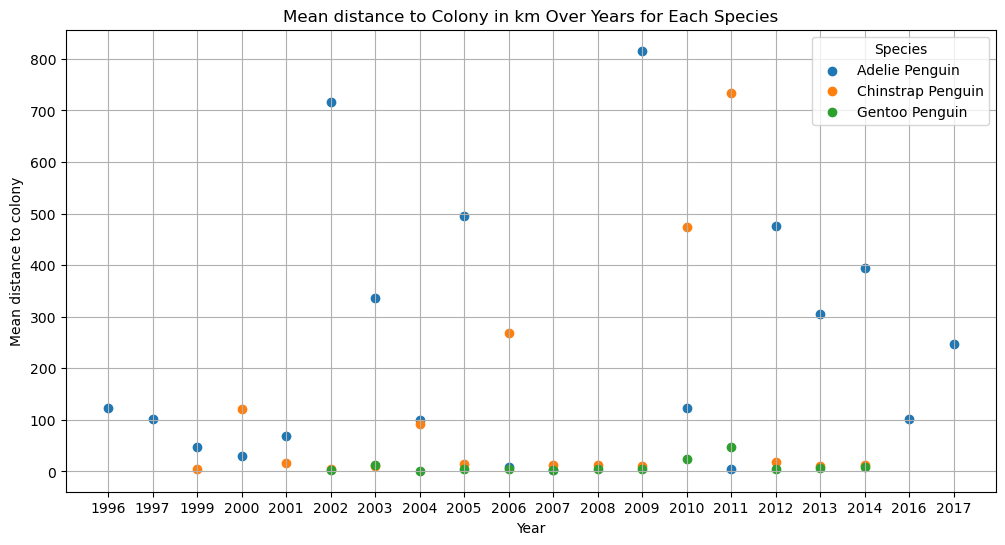

In [93]:
plt.figure(figsize=(12, 6))

for specie in results_species['species'].unique():
    specie_data = results_species[results_species['species'] == specie]
    plt.scatter(specie_data['year'], specie_data['mean value'], label=specie)

plt.xlabel('Year')
plt.ylabel('Mean distance to colony')
plt.title('Mean distance to Colony in km Over Years for Each Species')
plt.legend(title='Species')
plt.grid(True)
plt.show()

In [94]:
# for each species and colony
species = df['common_name'].unique()
years = df_penguins_final['year'].unique()
results_species_colony = []
for year in years:
    for specie in species:
        print(specie)
        for colony in df[df['common_name'] == specie]['colony_name'].unique():
            df_specie = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony) & (df_penguins_final['year'] == year)]
            # Calculate mean deviation manually
            mean_value = df_specie['km_to_colony_mean'].mean()
            # mean_deviation = (df_specie['km_to_colony_mean'] - mean_value).abs().mean()
            results_species_colony.append({'year': year, 'species': specie, 'colony': colony, 'mean distance': mean_value})
            print(colony, mean_value)

Adelie Penguin
King George Island nan
Hope Bay nan
Powell Island/Peng colony nan
Signy Island/Gourlay nan
Signy Island/North Point nan
Admiralty Bay 123.10515308378803
Chinstrap Penguin
Laurie Island/Cape Geddes nan
Signy Island/Gourlay nan
Powell Island/Peng colony nan
Admiralty Bay nan
Cape Shirreff nan
Gentoo Penguin
Signy Island/North Point nan
Admiralty Bay nan
Cape Shirreff nan
Adelie Penguin
King George Island nan
Hope Bay nan
Powell Island/Peng colony nan
Signy Island/Gourlay nan
Signy Island/North Point nan
Admiralty Bay 102.65370037206847
Chinstrap Penguin
Laurie Island/Cape Geddes nan
Signy Island/Gourlay nan
Powell Island/Peng colony nan
Admiralty Bay nan
Cape Shirreff nan
Gentoo Penguin
Signy Island/North Point nan
Admiralty Bay nan
Cape Shirreff nan
Adelie Penguin
King George Island nan
Hope Bay nan
Powell Island/Peng colony nan
Signy Island/Gourlay 48.06696482654556
Signy Island/North Point nan
Admiralty Bay nan
Chinstrap Penguin
Laurie Island/Cape Geddes nan
Signy Islan

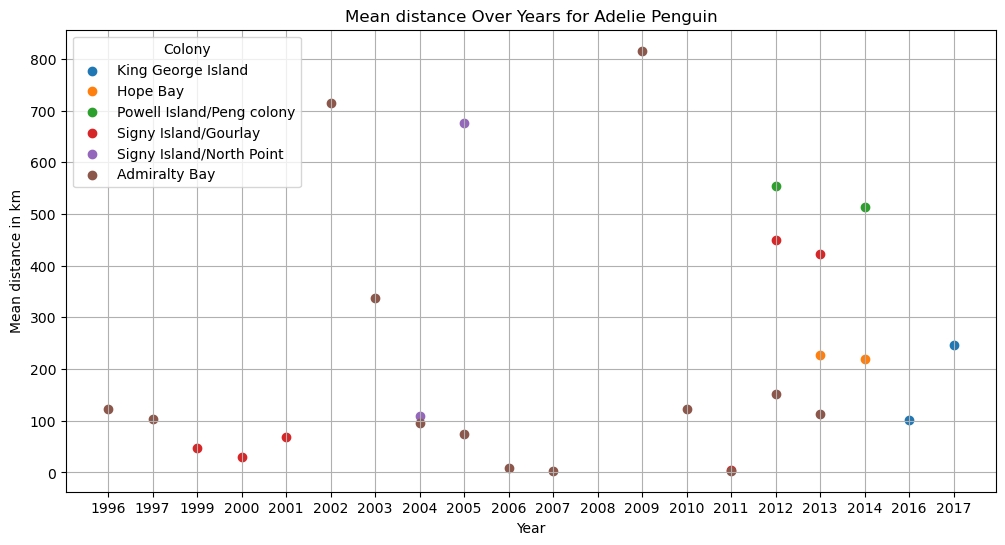

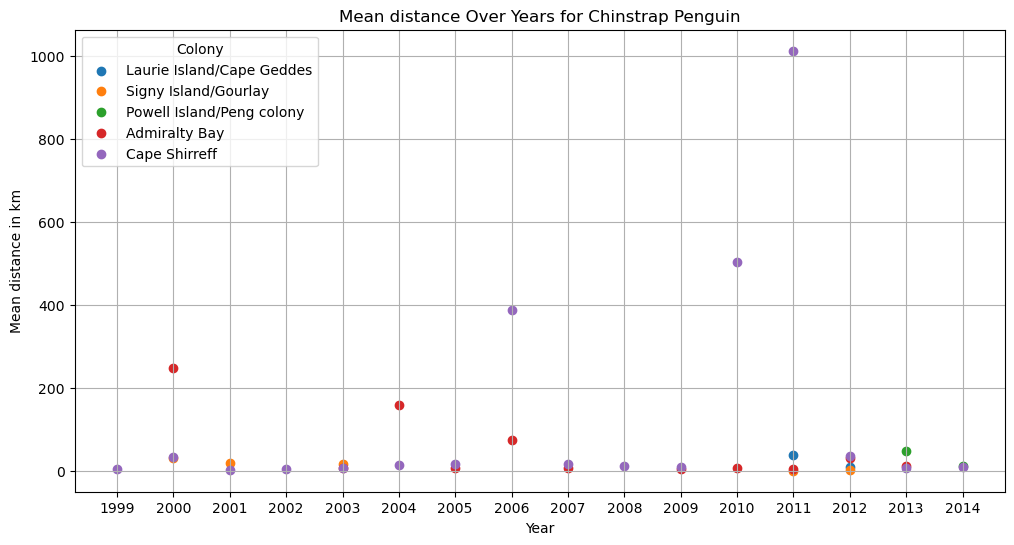

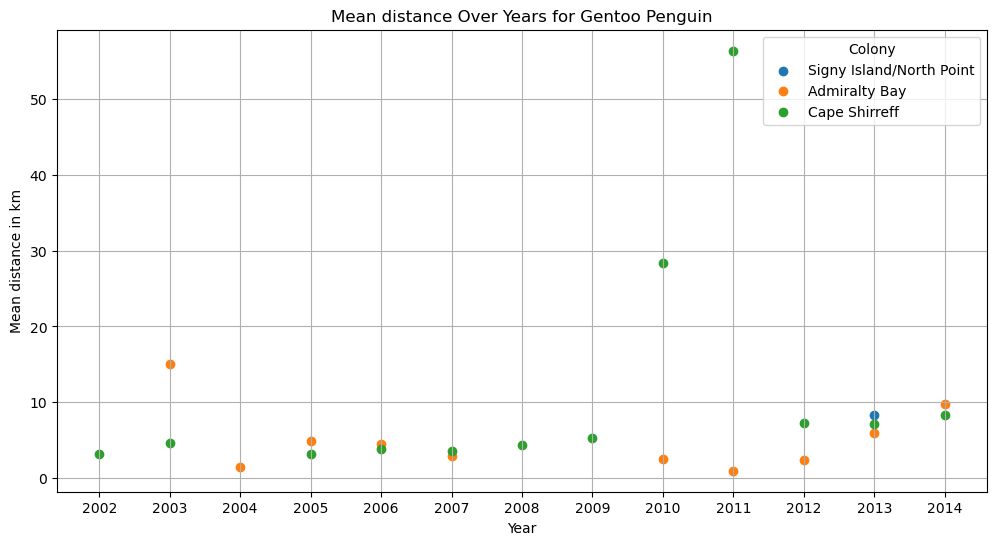

In [95]:
# plot the results in 3 different plots, one for each species
results_species_colony = pd.DataFrame(results_species_colony)

for specie in species:
    results_specie = results_species_colony[results_species_colony['species'] == specie]
    plt.figure(figsize=(12, 6))
    for colony in results_specie['colony'].unique():
        colony_data = results_specie[results_specie['colony'] == colony]
        plt.scatter(colony_data['year'], colony_data['mean distance'], label=colony)
    plt.xlabel('Year')
    plt.ylabel('Mean distance in km')
    plt.title(f'Mean distance Over Years for {specie}')
    plt.legend(title='Colony')
    plt.grid(True)
    plt.show()

In [126]:
# Convert years to strings
available_years = [str(x) for x in range(1996, 2018)]
available_years = np.array(available_years)

# Ensure the 'year' column in df_penguins_final is of type string
df_penguins_final['year'] = df_penguins_final['year'].astype(str)

# For each species and colony, see if there is data for more than 10 years
species = df['common_name'].unique()
results_species_colony = []

for specie in species:
    for colony in df[df['common_name'] == specie]['colony_name'].unique():
        years_with_data = df_penguins_final[(df_penguins_final['common_name'] == specie) & (df_penguins_final['colony_name'] == colony)]['year'].unique()
        if len(years_with_data) >= 8:
            print(f'{specie} , {colony} has data for more than 5 years')
        else:
            print('--')

--
--
--
--
--
Adelie Penguin , Admiralty Bay has data for more than 5 years
--
--
--
Chinstrap Penguin , Admiralty Bay has data for more than 5 years
Chinstrap Penguin , Cape Shirreff has data for more than 5 years
--
Gentoo Penguin , Admiralty Bay has data for more than 5 years
Gentoo Penguin , Cape Shirreff has data for more than 5 years
